In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pathlib

In [2]:
sys.path.append('/home/pdudenas/lib/NRSS/NRSS')

In [3]:
sys.path.append('/home/pdudenas/lib/cyrsoxs/build_pybind/lib')

In [4]:
from morphology import Morphology, Material, OpticalConstants

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using Cy-RSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fo

In [5]:
basePath = pathlib.Path('.').absolute()

In [6]:
energies = np.round(np.arange(275,300,.1),1)

In [7]:
energies

array([275. , 275.1, 275.2, 275.3, 275.4, 275.5, 275.6, 275.7, 275.8,
       275.9, 276. , 276.1, 276.2, 276.3, 276.4, 276.5, 276.6, 276.7,
       276.8, 276.9, 277. , 277.1, 277.2, 277.3, 277.4, 277.5, 277.6,
       277.7, 277.8, 277.9, 278. , 278.1, 278.2, 278.3, 278.4, 278.5,
       278.6, 278.7, 278.8, 278.9, 279. , 279.1, 279.2, 279.3, 279.4,
       279.5, 279.6, 279.7, 279.8, 279.9, 280. , 280.1, 280.2, 280.3,
       280.4, 280.5, 280.6, 280.7, 280.8, 280.9, 281. , 281.1, 281.2,
       281.3, 281.4, 281.5, 281.6, 281.7, 281.8, 281.9, 282. , 282.1,
       282.2, 282.3, 282.4, 282.5, 282.6, 282.7, 282.8, 282.9, 283. ,
       283.1, 283.2, 283.3, 283.4, 283.5, 283.6, 283.7, 283.8, 283.9,
       284. , 284.1, 284.2, 284.3, 284.4, 284.5, 284.6, 284.7, 284.8,
       284.9, 285. , 285.1, 285.2, 285.3, 285.4, 285.5, 285.6, 285.7,
       285.8, 285.9, 286. , 286.1, 286.2, 286.3, 286.4, 286.5, 286.6,
       286.7, 286.8, 286.9, 287. , 287.1, 287.2, 287.3, 287.4, 287.5,
       287.6, 287.7,

In [8]:
x = np.arange(0,512)
y = x.copy()
xx, yy = np.meshgrid(x,y)

In [9]:
x_center = xx.shape[0]//2
y_center = xx.shape[0]//2
radius = 10
shell = 5
core_idx = ((xx-x_center)**2 + (yy-y_center)**2 < radius**2)
shell_idx = ((xx-x_center)**2 + (yy-y_center)**2 >= radius**2) & ((xx-x_center)**2 + (yy-y_center)**2 < (radius+shell)**2)
phi_material1 = np.zeros(xx.shape)
phi_material1[core_idx] = 1
shell_material = np.zeros(xx.shape)
shell_material[shell_idx] = 1

combined = phi_material1 + shell_material

[{(231.0, 281.0)}, {(231.0, 281.0)}]

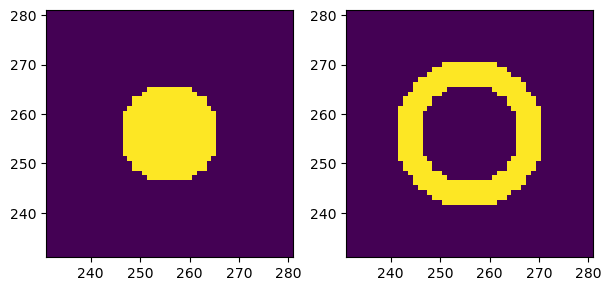

In [10]:
window = 25
fig, ax = plt.subplots(1,2,figsize=(6,3),constrained_layout=True)
ax[0].imshow(phi_material1)
ax[1].imshow(shell_material)
[{axes.set_xlim(x_center-window,x_center+window), axes.set_ylim(y_center-window,y_center+window)} for axes in ax]

In [11]:
from skimage.filters import sobel_v, sobel_h, sobel, gaussian

In [12]:
angles = np.arctan2(-sobel_h(combined),-sobel_v(combined))
angles_smoothed = np.arctan2(-sobel_h(gaussian(combined,sigma=5)),-sobel_v(gaussian(combined,sigma=5)))

In [13]:
# create Euler arrays
theta = np.zeros(xx.shape)
psi = theta.copy()

# Use Boolean indexing to only grab the orientation in the shell region
theta[shell_material.astype(bool)] = np.pi/2
psi[shell_material.astype(bool)] = angles_smoothed[shell_material.astype(bool)]


# I am bounding the orientation angles from 0 to pi for visualization, but Cy-RSoXS will accept any angle
# psi[psi > np.pi/2] %= -np.pi/2
# psi[psi < -np.pi/2] %= np.pi/2
psi = np.mod(psi,np.pi)

In [14]:
mat1_Vfrac = combined.copy() # volume fraction of all polyethylene (core and shell)
mat1_S = shell_material.copy() # alignment magnitude for polyethylene. Only the shell is aligned.

mat2_Vfrac = np.ones(xx.shape)
mat2_Vfrac -= mat1_Vfrac # everywhere there isn't polyethylene, we have vacuum

# we have no alignment for vacuum, and leave the euler angles as all zeros
mat2_S = np.zeros(xx.shape)
mat2_theta = mat2_S.copy()
mat2_psi = mat2_S.copy()

In [15]:
NumXY = xx.shape[0]
mat1_Vfrac = np.reshape(mat1_Vfrac,(1,NumXY,NumXY))
mat1_S = np.reshape(mat1_S,(1,NumXY,NumXY))
mat1_psi = np.reshape(psi,(1,NumXY,NumXY))
mat1_theta = np.reshape(theta,(1,NumXY,NumXY))

mat2_Vfrac = np.reshape(mat2_Vfrac,(1,NumXY,NumXY))
mat2_S = np.reshape(mat2_S,(1,NumXY,NumXY))
mat2_theta = np.reshape(mat2_theta,(1,NumXY,NumXY))
mat2_psi = np.reshape(mat2_psi,(1,NumXY,NumXY))

In [16]:
materialPath = pathlib.Path('/home/pdudenas/lib/NRSS/tutorials/coreshell_disk/')

In [17]:
# load optical constants from previous Material1.txt file
mat1_consts = OpticalConstants.load_matfile(pathlib.Path(materialPath,'Material1.txt'),name='Material 1')

#create Material objects to hold the relevant voxel and optical constant information
mat1 = Material(materialID=1,Vfrac=mat1_Vfrac,S=mat1_S,
                psi=mat1_psi,theta=mat1_theta,energies=energies,
                opt_constants=mat1_consts.opt_constants,name='Material 1')

#automatically assigns zeros for optical constants if the name is vacuum
mat2 = Material(materialID=2,Vfrac=mat2_Vfrac,S=mat2_S,
                psi=mat2_psi,theta=mat2_theta,energies=energies,name='vacuum')

In [18]:
morph1 = Morphology(2,materials={1:mat1,2:mat2},PhysSize=5.0,create_CyObject=True)

In [19]:
# Can ignore the warnings below - these keys have default values in CyRSoXS
morph1.load_config(pathlib.Path(materialPath,'config.txt'))

/home/pdudenas/lib/NRSS/NRSS/morphology.py:177: UserWarning: AlgorithmType is currently not implemented
  warnings.warn(f'{key} is currently not implemented')
/home/pdudenas/lib/NRSS/NRSS/morphology.py:177: UserWarning: NumThreads is currently not implemented
  warnings.warn(f'{key} is currently not implemented')
/home/pdudenas/lib/NRSS/NRSS/morphology.py:177: UserWarning: DumpMorphology is currently not implemented
  warnings.warn(f'{key} is currently not implemented')
/home/pdudenas/lib/NRSS/NRSS/morphology.py:177: UserWarning: ScatterApproach is currently not implemented
  warnings.warn(f'{key} is currently not implemented')
/home/pdudenas/lib/NRSS/NRSS/morphology.py:177: UserWarning: RotMask is currently not implemented
  warnings.warn(f'{key} is currently not implemented')


In [20]:
morph1.validate_all()

inputData has passed validation
OpticalConstants has passed validation
voxelData has passed validation


All CyRSoXS objects have passed validation, you can run your simulation


In [21]:
scattering_data = morph1.run(stdout=False,stderr=False)

[INFO] 2D computation enabled

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = NVIDIA GeForce GTX 1650 SUPER] : 275eV -> 299.9eV
 [STAT] Energy = 275 starting 
 [STAT] Energy = 275.1 starting 
 [STAT] Energy = 275.2 starting 
 [STAT] Energy = 275.3 starting 
 [STAT] Energy = 275.4 starting 
 [STAT] Energy = 275.5 starting 
 [STAT] Energy = 275.6 starting 
 [STAT] Energy = 275.7 starting 
 [STAT] Energy = 275.8 starting 
 [STAT] Energy = 275.9 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 276.1 starting 
 [STAT] Energy = 276.2 starting 
 [STAT] Energy = 276.3 starting 
 [STAT] Energy = 276.4 starting 
 [STAT] Energy = 276.5 starting 
 [STAT] Energy = 276.6 starting 
 [STAT] Energy = 276.7 starting 
 [STAT] Energy = 276.8 starting 
 [STAT] Energy = 276.9 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 277.1 starting 
 [STAT] Energy = 277.2 starting 
 [STAT] Energy = 277.3 starting 
 [STAT] Energy = 277.4 starting 
 [STAT] Energy = 277.5 starting 
 [STAT]

In [22]:
from matplotlib.colors import LogNorm

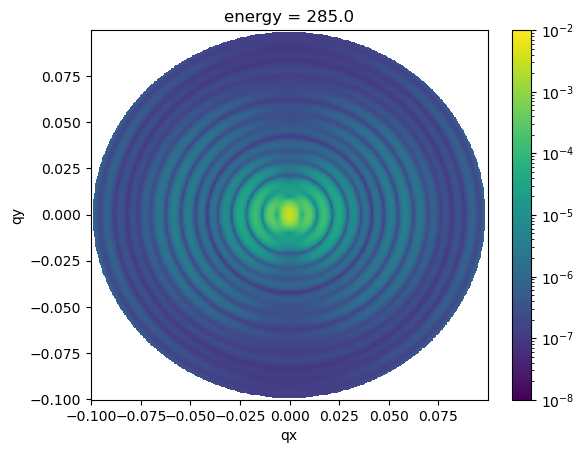

In [23]:
scattering_data.sel(energy=285.0).plot(norm=LogNorm(1e-8,1e-2))